In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "../data"



## 【現状のデータファイル概要】

* `train.csv`：トレーニングデータ（センサ時系列＋ラベル列含む）
* `train_demographics.csv`：トレーニング対象の被験者属性
* `test.csv`：テスト用データ（ラベル無し）
* `test_demographics.csv`：テスト対象の被験者属性
* `kaggle_evaluation/`：Kaggle提出評価用のサーバ・プロトコル定義ファイル群（提出形式や検証の補助用）

【補足】

* `train_features.csv`と`train_labels.csv`は一体化して`train.csv`形式で提供されている模様
* センサ時系列＋ジェスチャー名・ターゲット（BFRB判定）が`train.csv`内に含まれる構造と思われます
* `.proto`系ファイルは提出シミュレーション用途（後で使うがEDA段階では不要）


### ① train.csvの読み込み・確認


In [3]:

import pandas as pd
df = pd.read_csv("../data/train.csv")
df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0



## 【train.csvの構造要点】

* `row_id`：ユニークID（`sequence_id`＋ステップ情報含む）
* `sequence_type`：`Target`＝BFRB系、`Non-Target`＝非BFRB
* `sequence_id`：シーケンス単位のID（これで1動作まとまる）
* `sequence_counter`：時系列ステップ番号
* `subject`：被験者ID
* `orientation`：姿勢情報（Seated, Standingなど）
* `behavior`：行動詳細（自然文）
* `phase`：動作区間（Transition/Gesture/Pause）
* `gesture`：ジェスチャー名称（分類対象）
* `acc_x` ～：IMU・熱・距離センサ多数（総341列）

【補足】

* `tof_*`：距離センサ系、`-1`は欠損・センサ不感領域
* `gesture`が分類ターゲット、`sequence_type`がBFRB/非BFRBの二値分類に利用
* `orientation`や`phase`は特徴量エンジニアリング候補

---



### ② BFRB割合・ジェスチャー分布


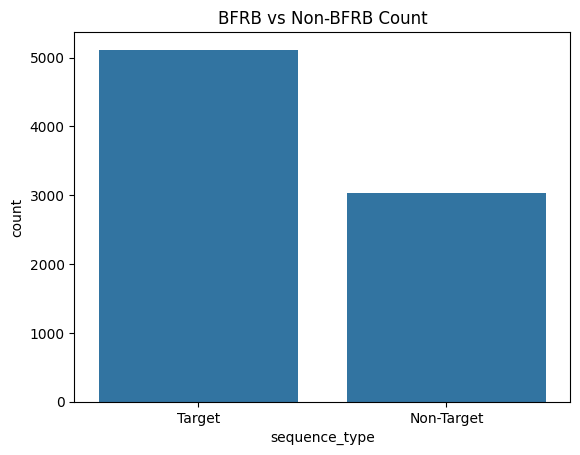

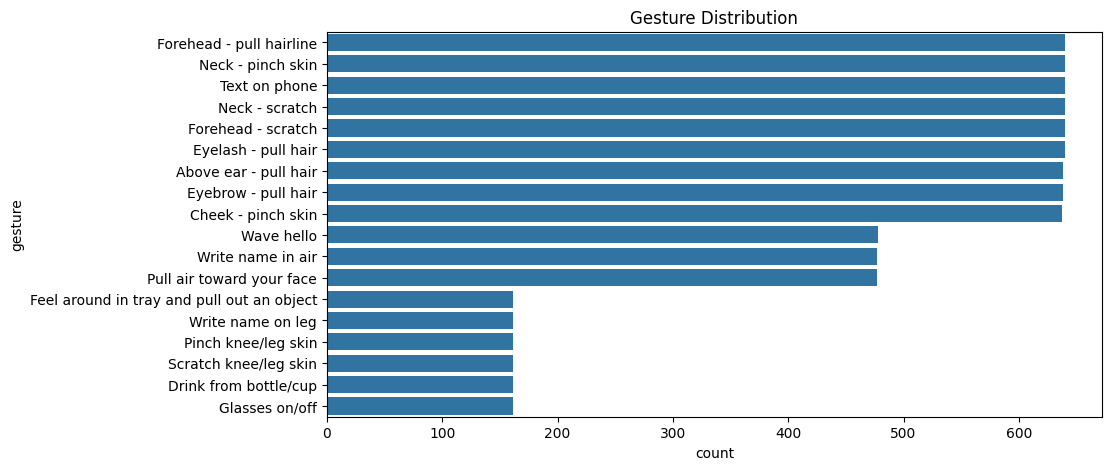

In [5]:
# シーケンス単位で重複除去
seq_info = df.drop_duplicates(subset="sequence_id")

# BFRB割合
sns.countplot(x="sequence_type", data=seq_info)
plt.title("BFRB vs Non-BFRB Count")
plt.show()

# ジェスチャー頻度
plt.figure(figsize=(10,5))
sns.countplot(y="gesture", data=seq_info, order=seq_info['gesture'].value_counts().index)
plt.title("Gesture Distribution")
plt.show()




### ③ センサ時系列の波形可視化（加速度例）



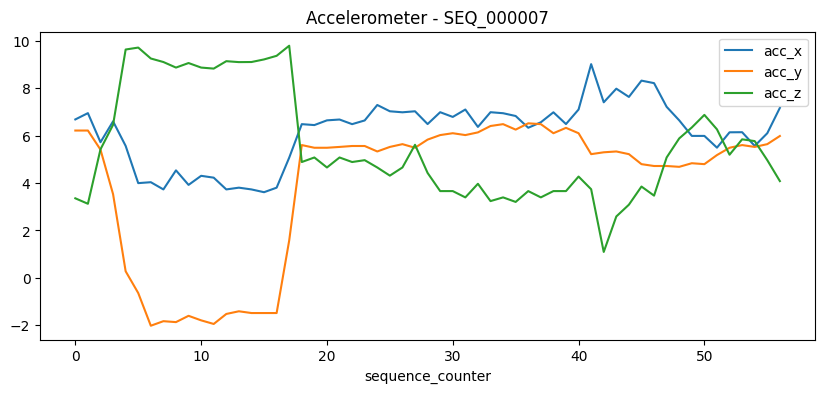

In [6]:

seq_id = df['sequence_id'].iloc[0]
sample = df[df['sequence_id'] == seq_id]

sample.plot(x='sequence_counter', y=['acc_x', 'acc_y', 'acc_z'], figsize=(10,4), title=f"Accelerometer - {seq_id}")
plt.show()


### ④ 距離センサ（ToF）例

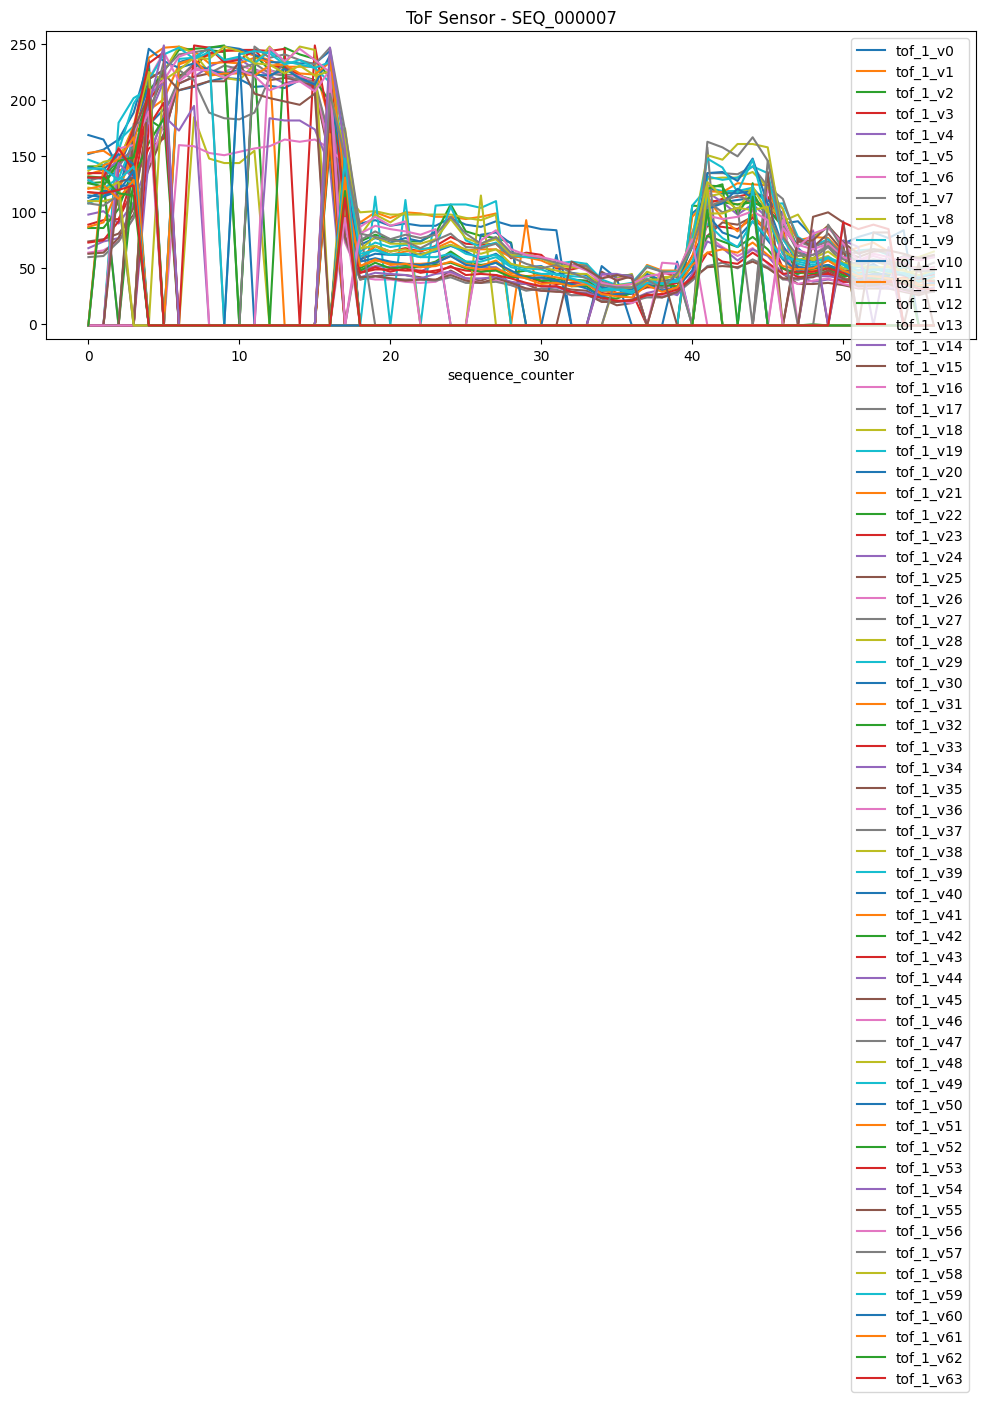

In [7]:

tof_cols = [col for col in df.columns if "tof_1" in col]
sample.plot(x='sequence_counter', y=tof_cols, figsize=(12,4), title=f"ToF Sensor - {seq_id}")
plt.show()


## 【現状のEDA観察メモ】

✅ BFRB（Target）と非BFRB（Non-Target）のサンプル数に偏りあり
✅ ジェスチャー分布も偏っており、上位はBFRB系中心
✅ 加速度（IMU）は明確な動きの変化を捉えている
✅ 距離センサ（ToF）は一部区間のみ応答、欠損（`-1.0`）多めだが、接近タイミングの情報量は大きい

### ① 熱センサ（`thm_*`）時系列の可視化

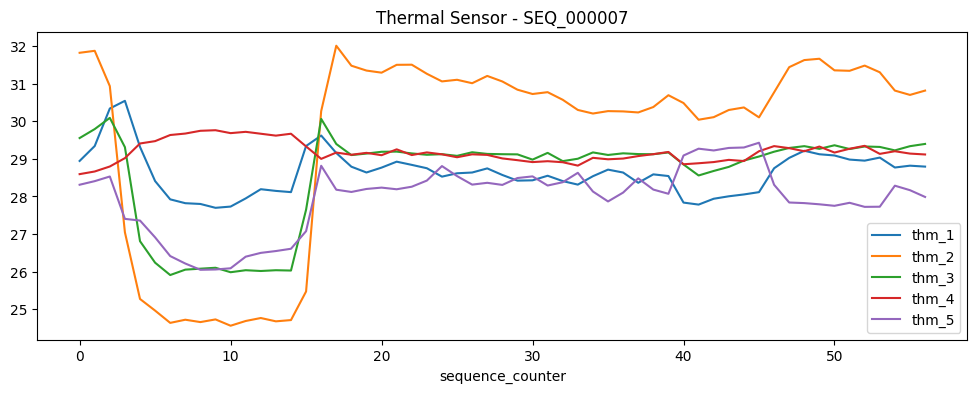

In [8]:

thm_cols = [col for col in df.columns if "thm_" in col]
sample.plot(x='sequence_counter', y=thm_cols, figsize=(12,4), title=f"Thermal Sensor - {seq_id}")
plt.show()




### ② 被験者ごとの偏り確認
* 特定被験者の偏重があるか確認
* モデル汎化のため、被験者依存を減らす設計が必要か見極め


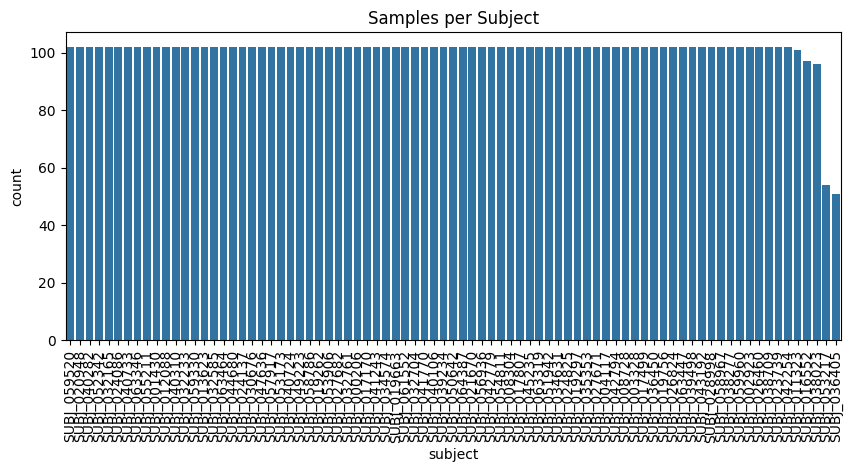

In [9]:

plt.figure(figsize=(10,4))
sns.countplot(x="subject", data=seq_info, order=seq_info['subject'].value_counts().index)
plt.title("Samples per Subject")
plt.xticks(rotation=90)
plt.show()


### ③ `phase`・`orientation`の利用可能性分析
`phase`（Transition/Gesture/Pause）区分や`orientation`（姿勢情報）が、動作ごとの特徴差に寄与する可能性あり。


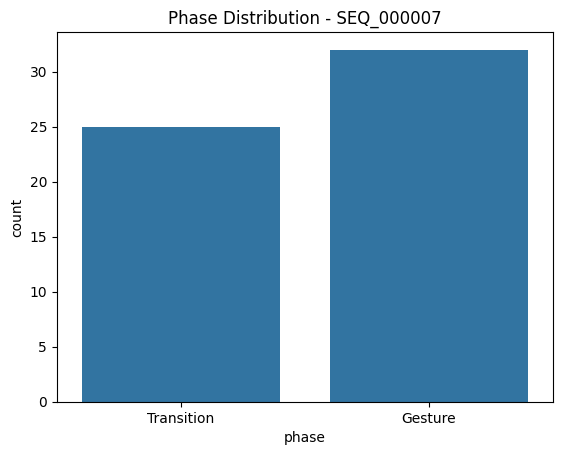

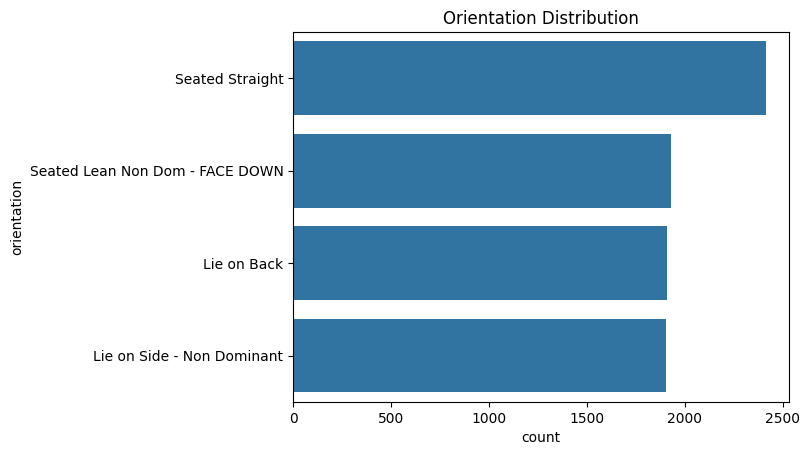

In [10]:

sns.countplot(x="phase", data=sample)
plt.title(f"Phase Distribution - {seq_id}")
plt.show()

sns.countplot(y="orientation", data=seq_info, order=seq_info['orientation'].value_counts().index)
plt.title("Orientation Distribution")
plt.show()

## 被験者・データ基本情報整理コード例



In [12]:
import pandas as pd

df = pd.read_csv("../data/train.csv")

# シーケンス単位に重複除去して集計用データを作成
seq_info = df.drop_duplicates(subset=["sequence_id", "subject"])

# 被験者数
num_subjects = seq_info['subject'].nunique()
print(f"被験者数: {num_subjects}")

# 被験者ごとのシーケンス数分布
seq_per_subject = seq_info.groupby('subject').size()
print("被験者ごとのシーケンス数（件）")
print(seq_per_subject.describe())

# シーケンスごとの時間長（step最大値 +1と仮定）
seq_lengths = df.groupby('sequence_id')['sequence_counter'].max() + 1
print("シーケンス長（時間ステップ数）の統計")
print(seq_lengths.describe())

# 被験者ごとの平均シーケンス長
mean_length_per_subject = df.groupby('subject').apply(
    lambda g: g.groupby('sequence_id')['sequence_counter'].max().mean() + 1
)
print("被験者ごとの平均シーケンス長")
print(mean_length_per_subject.describe())


被験者数: 81
被験者ごとのシーケンス数（件）
count     81.000000
mean     100.629630
std        7.757971
min       51.000000
25%      102.000000
50%      102.000000
75%      102.000000
max      102.000000
dtype: float64
シーケンス長（時間ステップ数）の統計
count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
Name: sequence_counter, dtype: float64
被験者ごとの平均シーケンス長
count     81.000000
mean      70.639193
std        9.108634
min       57.509804
25%       64.617647
50%       68.421569
75%       74.686275
max      106.352941
dtype: float64


/tmp/ipykernel_601856/636190979.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_length_per_subject = df.groupby('subject').apply(


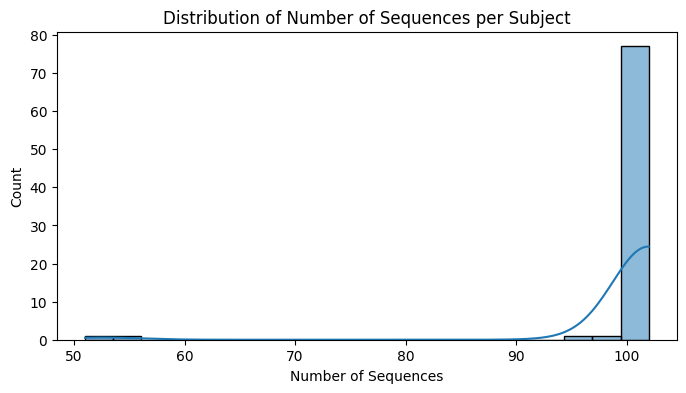

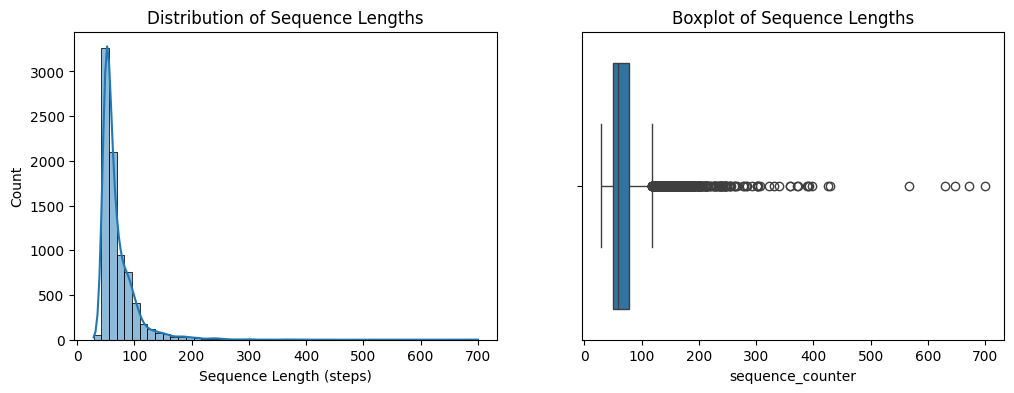

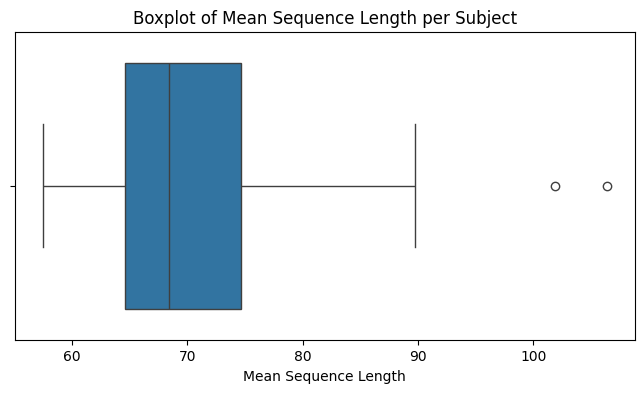

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 被験者ごとのシーケンス数分布ヒストグラム
plt.figure(figsize=(8,4))
sns.histplot(seq_per_subject, bins=20, kde=True)
plt.title("Distribution of Number of Sequences per Subject")
plt.xlabel("Number of Sequences")
plt.ylabel("Count")
plt.show()

# シーケンス長（時間ステップ数）のヒストグラムと箱ひげ図
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length (steps)")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.boxplot(x=seq_lengths)
plt.title("Boxplot of Sequence Lengths")

plt.show()

# 被験者ごとの平均シーケンス長分布（箱ひげ図）
plt.figure(figsize=(8,4))
sns.boxplot(x=mean_length_per_subject)
plt.title("Boxplot of Mean Sequence Length per Subject")
plt.xlabel("Mean Sequence Length")
plt.show()


In [14]:
! ls ../data

cmi-detect-behavior-with-sensor-data.zip  test_demographics.csv
kaggle_evaluation			  train.csv
test.csv				  train_demographics.csv




## test.csv 構造確認とEDAコード例


### ポイント

* `test.csv`はラベルなしのセンサ時系列データが主
* シーケンス長の分布がトレーニングデータと近いか確認
* サンプル波形を確認し、データの欠損や異常がないか観察

---


(107, 336)
Index(['row_id', 'sequence_id', 'sequence_counter', 'subject', 'acc_x',
       'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y',
       ...
       'tof_5_v54', 'tof_5_v55', 'tof_5_v56', 'tof_5_v57', 'tof_5_v58',
       'tof_5_v59', 'tof_5_v60', 'tof_5_v61', 'tof_5_v62', 'tof_5_v63'],
      dtype='object', length=336)
              row_id sequence_id  sequence_counter      subject      acc_x  \
0  SEQ_000001_000000  SEQ_000001                 0  SUBJ_055840   9.039062   
1  SEQ_000001_000001  SEQ_000001                 1  SUBJ_055840   9.421875   
2  SEQ_000001_000002  SEQ_000001                 2  SUBJ_055840  10.160156   
3  SEQ_000001_000003  SEQ_000001                 3  SUBJ_055840   9.773438   
4  SEQ_000001_000004  SEQ_000001                 4  SUBJ_055840   9.195312   

      acc_y     acc_z     rot_w     rot_x     rot_y  ...  tof_5_v54  \
0  5.261719  0.800781  0.367188 -0.397400 -0.629028  ...       97.0   
1  3.460938 -1.113281  0.353882 -0.507141 -0.652710  ...      17

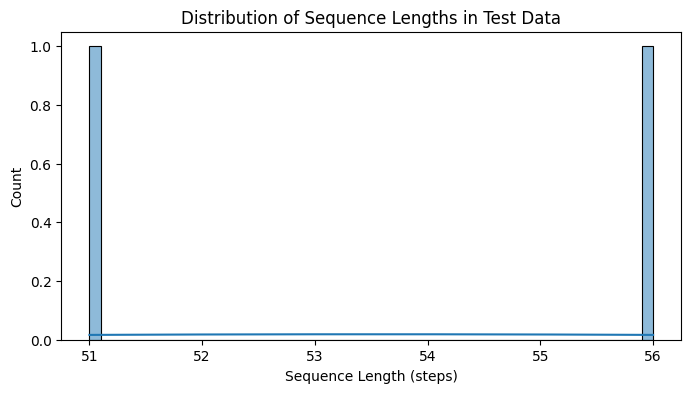

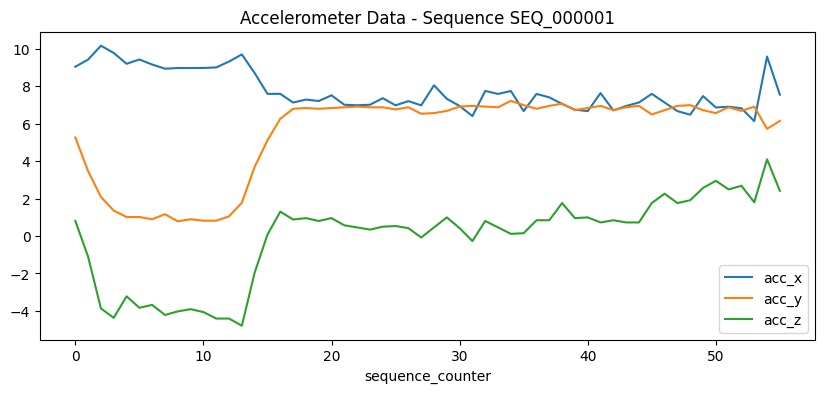

In [16]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データ読み込み
test_df = pd.read_csv("../data/test.csv")

# 基本情報表示
print(test_df.shape)
print(test_df.columns)
print(test_df.head())

# sequenceごとの件数（ステップ数）分布
seq_counts = test_df.groupby('sequence_id').size()
print(seq_counts.describe())

# sequence長のヒストグラム
plt.figure(figsize=(8,4))
sns.histplot(seq_counts, bins=50, kde=True)
plt.title("Distribution of Sequence Lengths in Test Data")
plt.xlabel("Sequence Length (steps)")
plt.ylabel("Count")
plt.show()

# 主なセンサーデータの例（最初のsequenceの加速度波形）
seq_id = test_df['sequence_id'].iloc[0]
sample = test_df[test_df['sequence_id'] == seq_id]

sample.plot(x='sequence_counter', y=['acc_x', 'acc_y', 'acc_z'], figsize=(10,4), title=f"Accelerometer Data - Sequence {seq_id}")
plt.show()




## 被験者属性データ読み込みと確認コード例

```python
```

---

### ポイント

* 主要なカテゴリカル・数値属性の分布を確認
* 欠損値があれば補完や扱い方の検討必要
* `subject`列は被験者IDとして統合や分割に使う

---

実行してわかった内容を教えてください。次の分析や処理案を出します。


Train Demographics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               81 non-null     object 
 1   adult_child           81 non-null     int64  
 2   age                   81 non-null     int64  
 3   sex                   81 non-null     int64  
 4   handedness            81 non-null     int64  
 5   height_cm             81 non-null     float64
 6   shoulder_to_wrist_cm  81 non-null     int64  
 7   elbow_to_wrist_cm     81 non-null     float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.2+ KB
None
       subject  adult_child  age  sex  handedness  height_cm  \
0  SUBJ_000206            1   41    1           1      172.0   
1  SUBJ_001430            0   11    0           1      167.0   
2  SUBJ_002923            1   28    1           0      164.0   
3  SUBJ_003328            1   33    1         

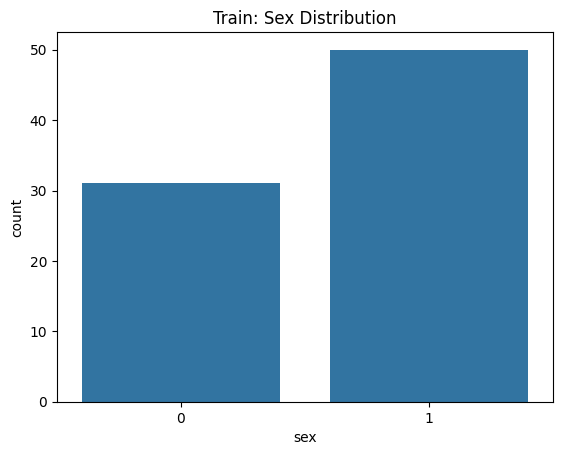

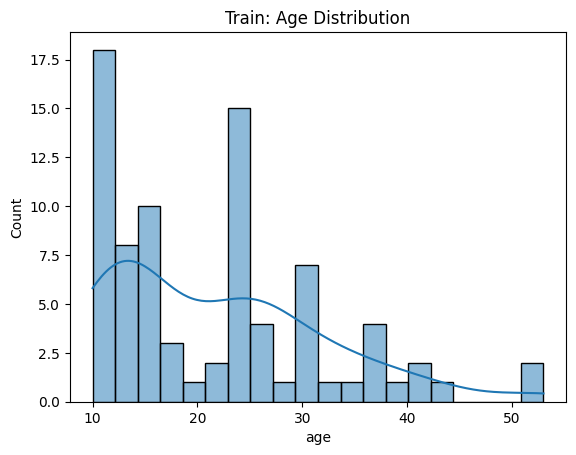

Train subjects: 81
Test subjects: 2


In [17]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ファイル読み込み
train_demo = pd.read_csv("../data/train_demographics.csv")
test_demo = pd.read_csv("../data/test_demographics.csv")

# 基本情報表示
print("Train Demographics")
print(train_demo.info())
print(train_demo.head())
print(train_demo.describe(include='all'))

print("\nTest Demographics")
print(test_demo.info())
print(test_demo.head())
print(test_demo.describe(include='all'))

# カテゴリカル変数の例：性別分布（あれば）
if 'sex' in train_demo.columns:
    sns.countplot(x='sex', data=train_demo)
    plt.title("Train: Sex Distribution")
    plt.show()

# 数値変数の例：年齢分布（あれば）
if 'age' in train_demo.columns:
    sns.histplot(train_demo['age'], bins=20, kde=True)
    plt.title("Train: Age Distribution")
    plt.show()

# 被験者数の確認
print(f"Train subjects: {train_demo['subject'].nunique()}")
print(f"Test subjects: {test_demo['subject'].nunique()}")



## 被験者属性の完全性チェック

```python
```

---


In [22]:

import pandas as pd

train = pd.read_csv("../data/train.csv")
train_demo = pd.read_csv("../data/train_demographics.csv")

# トレーニングの被験者IDリスト
train_subjects = set(train['subject'].unique())

# 属性ファイルの被験者IDリスト
demo_subjects = set(train_demo['subject'].unique())

# 属性情報が無い被験者の確認
missing_subjects = train_subjects - demo_subjects

print(f"属性情報がない被験者数: {len(missing_subjects)}")
if len(missing_subjects) > 0:
    print("漏れている被験者ID:", missing_subjects)
else:

    print("全員分の属性情報が揃っています。")

test = pd.read_csv("../data/test.csv")
test_demo = pd.read_csv("../data/test_demographics.csv")

test_subjects = set(test['subject'].unique())
test_demo_subjects = set(test_demo['subject'].unique())

missing_test_subjects = test_subjects - test_demo_subjects

print(f"テスト属性情報がない被験者数: {len(missing_test_subjects)}")
if len(missing_test_subjects) > 0:
    print("漏れている被験者ID:", missing_test_subjects)
else:
    print("全員分のテスト属性情報が揃っています。")

属性情報がない被験者数: 0
全員分の属性情報が揃っています。
テスト属性情報がない被験者数: 0
全員分のテスト属性情報が揃っています。
